In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import torch
import torchvision.transforms as transforms
import glob
import torchvision
import time
import random
from PIL import Image
from torch.utils.data import DataLoader, Dataset

In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
torch.cuda.is_available()

True

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

ROOT_DIR_TRAIN = "train"
ROOT_DIR_TEST = "test"

# Common transforms
common_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Prepare the Dataset
dataset = datasets.ImageFolder(root=ROOT_DIR_TRAIN, transform=common_transform)

train_size = int(0.80 * len(dataset))
valid_size = len(dataset) - train_size

# Use random_split to create train and validation datasets
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
test_dataset = datasets.ImageFolder(root=ROOT_DIR_TEST, transform=common_transform)

# Prepare the Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

In [6]:
num_images = len(dataset)
num_classes = len(dataset.classes)
print(f"Number of Images: {num_images}")
print(f"Number of Classes: {num_classes}")

Number of Images: 2316
Number of Classes: 27


In [7]:
num_images = len(test_dataset)
num_classes = len(test_dataset.classes)
print(f"Number of Images: {num_images}")
print(f"Number of Classes: {num_classes}")

Number of Images: 236
Number of Classes: 27


In [8]:
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(valid_dataset)}")
print(f"Number of test images: {len(test_dataset)}")

Number of training images: 1852
Number of validation images: 464
Number of test images: 236


In [10]:
from torchvision import models
dir(models)

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'MobileNetV3',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mobilenetv2',
 'mobilenetv3',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 '

In [11]:
!pip install torchsummary

In [13]:
import torch.nn as nn
from torchsummary import summary
from torchvision import models

# Load a pre-trained SqueezeNet model
squeezenet = models.squeezenet1_1(pretrained=True)

# Set the number of classes to match your dataset
num_classes = 27

# Modify the fully connected layer to match the number of classes
squeezenet.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))

# Set the device (CPU or GPU)
squeezenet.to(device)

# Display the model summary
summary(squeezenet, input_size=(3, 224, 224))

c:\Users\NAVAPOOM PUNSATHIT\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 111, 111]           1,792
              ReLU-2         [-1, 64, 111, 111]               0
         MaxPool2d-3           [-1, 64, 55, 55]               0
            Conv2d-4           [-1, 16, 55, 55]           1,040
              ReLU-5           [-1, 16, 55, 55]               0
            Conv2d-6           [-1, 64, 55, 55]           1,088
              ReLU-7           [-1, 64, 55, 55]               0
            Conv2d-8           [-1, 64, 55, 55]           9,280
              ReLU-9           [-1, 64, 55, 55]               0
             Fire-10          [-1, 128, 55, 55]               0
           Conv2d-11           [-1, 16, 55, 55]           2,064
             ReLU-12           [-1, 16, 55, 55]               0
           Conv2d-13           [-1, 64, 55, 55]           1,088
             ReLU-14           [-1, 64,

In [14]:
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, Subset
import numpy as np

def train_model(model, criterion, optimizer, dataloader, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc

def validate_model(model, criterion, dataloader, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc

In [15]:
def test_model(model, criterion, test_loader, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(test_loader.dataset)
        epoch_acc = running_corrects.double() / len(test_loader.dataset)

    return epoch_loss, epoch_acc

In [14]:
torch.backends.cudnn.benchmark = True

In [16]:
# Set the number of folds
num_folds = 5

# Prepare the data
X = np.arange(len(dataset))
y = np.array([label for _, label in dataset.imgs])

# Set up the StratifiedKFold
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize lists to store fold results
fold_train_losses = []
fold_valid_losses = []
fold_test_losses = []
fold_train_accs = []
fold_valid_accs = []
fold_test_accs = []

for fold, (train_index, valid_index) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Create data loaders for the current fold
    train_data = Subset(dataset, train_index)
    valid_data = Subset(dataset, valid_index)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Load and prepare the model
    model = models.squeezenet1_1(pretrained=True)
    model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
    model.to(device)

    # Set the criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Train and validate the model
    num_epochs = 50
    epoch_train_losses = []
    epoch_valid_losses = []
    epoch_test_losses = []
    epoch_train_accs = []
    epoch_valid_accs = []
    epoch_test_accs = []
    for epoch in range(num_epochs):
        train_loss, train_acc = train_model(model, criterion, optimizer, train_loader, device)
        valid_loss, valid_acc = validate_model(model, criterion, valid_loader, device)
        test_loss, test_acc = test_model(model, criterion, test_loader, device)

        epoch_train_losses.append(train_loss)
        epoch_valid_losses.append(valid_loss)
        epoch_test_losses.append(test_loss)
        epoch_train_accs.append(train_acc)
        epoch_valid_accs.append(valid_acc)
        epoch_test_accs.append(test_acc)

        print(f"Epoch {epoch + 1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f} Train Accuracy: {train_acc * 100:.4f} "
              f"Valid Loss: {valid_loss:.4f} Valid Accuracy: {valid_acc * 100:.4f} "
              f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc * 100:.4f}")

    fold_train_losses.append(epoch_train_losses)
    fold_valid_losses.append(epoch_valid_losses)
    fold_test_losses.append(epoch_test_losses)
    fold_train_accs.append(epoch_train_accs)
    fold_valid_accs.append(epoch_valid_accs)
    fold_test_accs.append(epoch_test_accs)

    print("Finished Fold")
    print("=" * 50)

Fold 1/5
Epoch 1/50: Train Loss: 3.0736 Train Accuracy: 12.3650 Valid Loss: 2.7114 Valid Accuracy: 23.7069 Test Loss: 2.9851 Test Accuracy: 16.1017
Epoch 2/50: Train Loss: 2.4119 Train Accuracy: 30.1836 Valid Loss: 2.2898 Valid Accuracy: 32.1121 Test Loss: 2.4222 Test Accuracy: 28.3898
Epoch 3/50: Train Loss: 1.9753 Train Accuracy: 42.4406 Valid Loss: 1.8811 Valid Accuracy: 43.7500 Test Loss: 2.0942 Test Accuracy: 38.1356
Epoch 4/50: Train Loss: 1.6353 Train Accuracy: 49.6220 Valid Loss: 1.8352 Valid Accuracy: 42.8879 Test Loss: 1.8425 Test Accuracy: 40.6780
Epoch 5/50: Train Loss: 1.4414 Train Accuracy: 53.6177 Valid Loss: 1.8527 Valid Accuracy: 45.0431 Test Loss: 1.9069 Test Accuracy: 41.9492
Epoch 6/50: Train Loss: 1.3042 Train Accuracy: 58.4233 Valid Loss: 1.8294 Valid Accuracy: 46.7672 Test Loss: 1.8721 Test Accuracy: 45.3390
Epoch 7/50: Train Loss: 1.2261 Train Accuracy: 60.7991 Valid Loss: 1.6905 Valid Accuracy: 50.0000 Test Loss: 1.6721 Test Accuracy: 49.1525
Epoch 8/50: Train 

In [17]:
# Evaluate the trained model on the training and validation sets for each fold.
squeezenet_avg_train_acc_k_folds = []
squeezenet_avg_val_acc_k_folds = []

def evaluate_accuracy(history, index):
    history_cpu = [item.cpu() for item in history]
    return sum(history_cpu) / len(history_cpu)

for i in range(num_folds):
    train_accuracy = evaluate_accuracy(fold_train_accs[i], 2)
    valid_accuracy = evaluate_accuracy(fold_valid_accs[i], 3)
    print(f'Fold {i + 1}/{num_folds}:')
    print(f'\tTraining Accuracy: {train_accuracy * 100:.2f}%')
    print(f'\tValidation Accuracy: {valid_accuracy * 100:.2f}%')
    squeezenet_avg_train_acc_k_folds.append(train_accuracy)
    squeezenet_avg_val_acc_k_folds.append(valid_accuracy)

# Compute the average training and validation accuracy over all folds.
overall_train_acc = sum(squeezenet_avg_train_acc_k_folds) / len(squeezenet_avg_train_acc_k_folds)
overall_val_acc = sum(squeezenet_avg_val_acc_k_folds) / len(squeezenet_avg_val_acc_k_folds)

# Calculate the average and standard deviation of the training and validation accuracy over all folds.
squeezenet_avg_train_acc = np.mean(squeezenet_avg_train_acc_k_folds)
squeezenet_std_train_acc = np.std(squeezenet_avg_train_acc_k_folds)
squeezenet_avg_val_acc = np.mean(squeezenet_avg_val_acc_k_folds)
squeezenet_std_val_acc = np.std(squeezenet_avg_val_acc_k_folds)

# Print the average and standard deviation of the training and validation accuracy over all folds.
print(f'\nAverage Training Accuracy over {num_folds}-fold Cross Validation: {squeezenet_avg_train_acc * 100:.2f}% +/- {squeezenet_std_train_acc * 100:.2f}%')
print(f'Average Validation Accuracy over {num_folds}-fold Cross Validation: {squeezenet_avg_val_acc * 100:.2f}% +/- {squeezenet_std_val_acc * 100:.2f}%')

Fold 1/5:
	Training Accuracy: 84.66%
	Validation Accuracy: 49.84%
Fold 2/5:
	Training Accuracy: 83.29%
	Validation Accuracy: 49.17%
Fold 3/5:
	Training Accuracy: 83.37%
	Validation Accuracy: 49.59%
Fold 4/5:
	Training Accuracy: 84.15%
	Validation Accuracy: 50.17%
Fold 5/5:
	Training Accuracy: 83.44%
	Validation Accuracy: 49.40%

Average Training Accuracy over 5-fold Cross Validation: 83.78% +/- 0.54%
Average Validation Accuracy over 5-fold Cross Validation: 49.64% +/- 0.35%


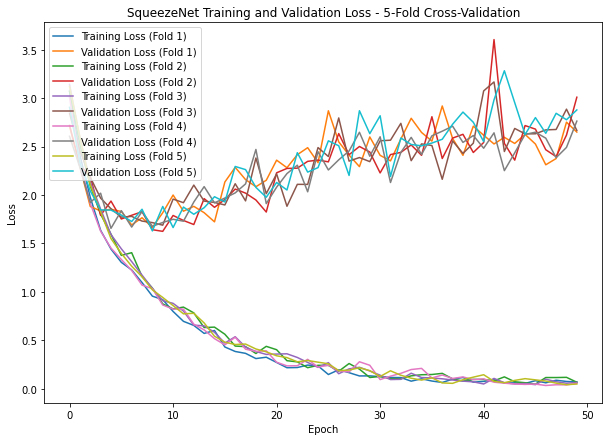

In [18]:
# Plot the training and validation loss for each epoch
model_name = "SqueezeNet"
plt.figure(figsize=(10, 7))
for fold in range(num_folds):
    plt.plot(fold_train_losses[fold], label=f'Training Loss (Fold {fold+1})')
    plt.plot(fold_valid_losses[fold], label=f'Validation Loss (Fold {fold+1})')

plt.title(f'{model_name} Training and Validation Loss - {num_folds}-Fold Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

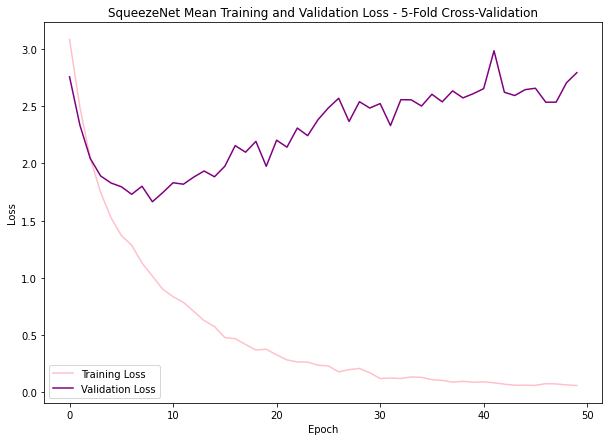

In [19]:
# Compute mean loss across all folds at each epoch
train_loss_mean = np.mean([np.array(fold_train_losses[i]) for i in range(num_folds)], axis=0)
valid_loss_mean = np.mean([np.array(fold_valid_losses[i]) for i in range(num_folds)], axis=0)

# Plot mean loss history
plt.figure(figsize=(10, 7))
plt.plot(train_loss_mean, label='Training Loss', color='pink')
plt.plot(valid_loss_mean, label='Validation Loss', color='purple')
plt.title(f'{model_name} Mean Training and Validation Loss - {num_folds}-Fold Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

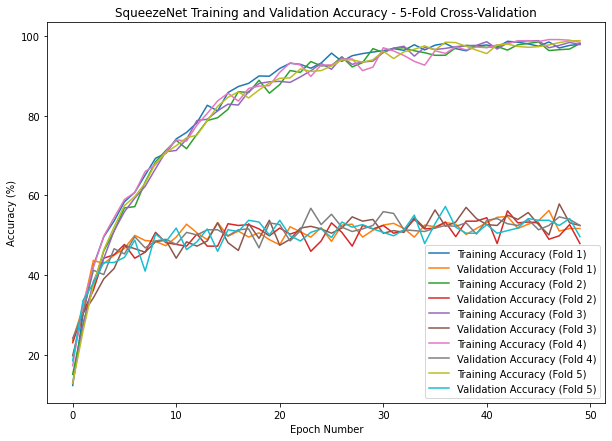

In [20]:
# Plot the training and validation accuracy for each epoch
plt.figure(figsize=(10, 7))
for fold in range(num_folds):
    plt.plot(np.array([acc.cpu() for acc in fold_train_accs[fold]]) * 100, label=f'Training Accuracy (Fold {fold+1})')
    plt.plot(np.array([acc.cpu() for acc in fold_valid_accs[fold]]) * 100, label=f'Validation Accuracy (Fold {fold+1})')

plt.title(f'{model_name} Training and Validation Accuracy - {num_folds}-Fold Cross-Validation')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

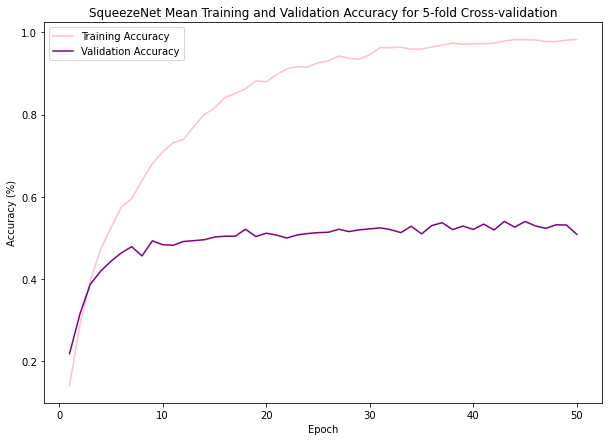

In [21]:
# Compute mean accuracy across all folds at each epoch
train_acc_mean = np.mean([np.array([acc.cpu() for acc in fold_train_accs[i]]) for i in range(num_folds)], axis=0)
valid_acc_mean = np.mean([np.array([acc.cpu() for acc in fold_valid_accs[i]]) for i in range(num_folds)], axis=0)

# Plot mean accuracy history
plt.figure(figsize=(10, 7))
plt.plot(np.arange(1, num_epochs + 1), train_acc_mean, label='Training Accuracy', color='pink')
plt.plot(np.arange(1, num_epochs + 1), valid_acc_mean, label='Validation Accuracy', color='purple')
plt.title(f'{model_name} Mean Training and Validation Accuracy for {num_folds}-fold Cross-validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


In [22]:
# Evaluate the trained model on the test sets for each fold.
squeezenet_avg_test_acc_k_folds = []

def evaluate_accuracy(history, index):
    history_cpu = [item.cpu() for item in history]
    return sum(history_cpu) / len(history_cpu)

for i in range(num_folds):
    test_accuracy = evaluate_accuracy(fold_test_accs[i], 2)
    print(f'Fold {i + 1}/{num_folds}:')
    print(f'\tTest Accuracy: {test_accuracy * 100:.2f}%')
    squeezenet_avg_test_acc_k_folds.append(test_accuracy)

# Compute the average test accuracy over all folds.
overall_test_acc = sum(squeezenet_avg_test_acc_k_folds) / len(squeezenet_avg_test_acc_k_folds)

# Calculate the average and standard deviation of the test accuracy over all folds.
squeezenet_avg_test_acc = np.mean(squeezenet_avg_test_acc_k_folds)
squeezenet_std_test_acc = np.std(squeezenet_avg_test_acc_k_folds)

# Print the average and standard deviation of the test accuracy over all folds.
print(f'\nAverage Test Accuracy over {num_folds}-fold Cross Validation: {squeezenet_avg_test_acc * 100:.2f}% +/- {squeezenet_std_test_acc * 100:.2f}%')

Fold 1/5:
	Test Accuracy: 46.57%
Fold 2/5:
	Test Accuracy: 46.30%
Fold 3/5:
	Test Accuracy: 47.43%
Fold 4/5:
	Test Accuracy: 45.94%
Fold 5/5:
	Test Accuracy: 43.97%

Average Test Accuracy over 5-fold Cross Validation: 46.04% +/- 1.15%


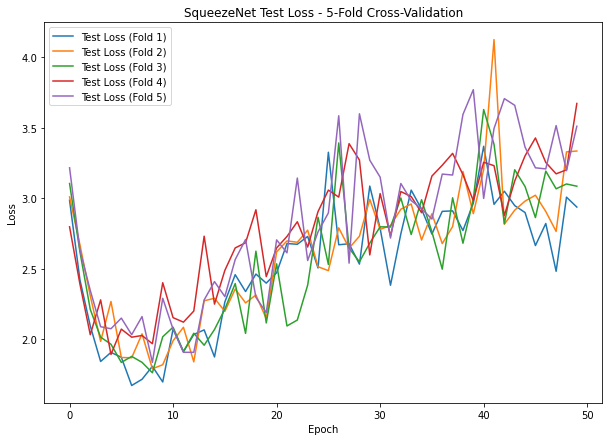

In [23]:
# Plot the test loss for each epoch
plt.figure(figsize=(10, 7))
for fold in range(num_folds):
    plt.plot(fold_test_losses[fold], label=f'Test Loss (Fold {fold+1})')

plt.title(f'{model_name} Test Loss - {num_folds}-Fold Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

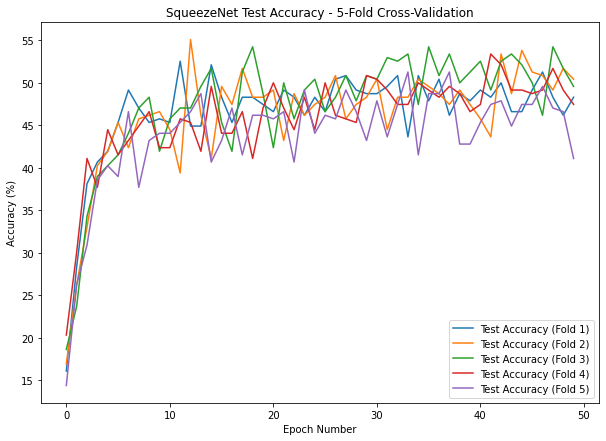

In [24]:
# Plot the test accuracy for each epoch
plt.figure(figsize=(10, 7))
for fold in range(num_folds):
    plt.plot(np.array([acc.cpu() for acc in fold_test_accs[fold]]) * 100, label=f'Test Accuracy (Fold {fold+1})')

plt.title(f'{model_name} Test Accuracy - {num_folds}-Fold Cross-Validation')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

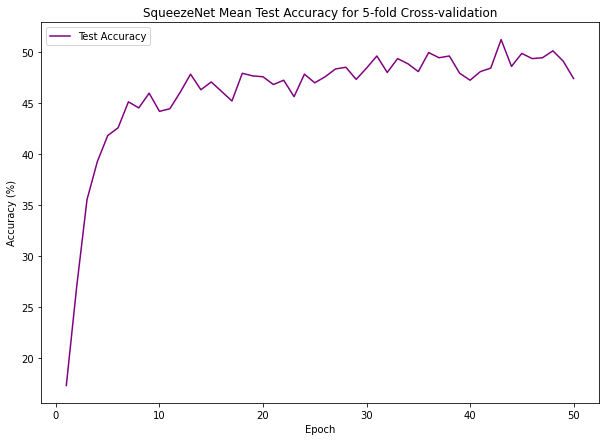

In [25]:
# Compute mean accuracy across all folds at each epoch
test_acc_mean = np.mean([np.array([acc.cpu() for acc in fold_test_accs[i]]) for i in range(num_folds)], axis=0)

# Plot mean accuracy history
plt.figure(figsize=(10, 7))
plt.plot(np.arange(1, num_epochs + 1), test_acc_mean * 100, label='Test Accuracy', color='purple')
plt.title(f'{model_name} Mean Test Accuracy for {num_folds}-fold Cross-validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [26]:
print("Classes: ")
class_names = test_dataset.classes
print(test_dataset.classes)

Classes: 
['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'grape leaf', 'grape leaf black rot']


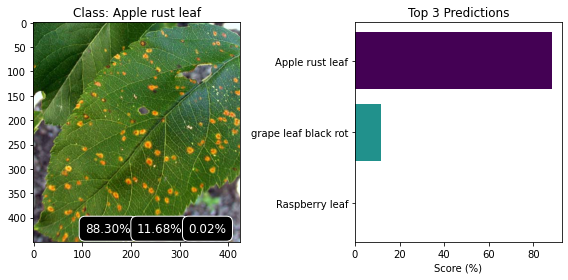

In [27]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def predict_single_image(model, image_path, device, top_k=3):
    model.eval()

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        top_probs, top_indices = torch.topk(probabilities, top_k)

    top_probs = top_probs.cpu().numpy().flatten()
    top_indices = top_indices.cpu().numpy().flatten()

    return top_probs, top_indices

import matplotlib.cm as cm

def display_image_with_predictions(image_path, top_probs, top_indices, class_names):
    image = Image.open(image_path).convert('RGB')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8, 4), ncols=2)
    
    ax1.imshow(image)
    ax1.axis('on')
    ax1.set_title(f"Class: {class_names[top_indices[0]]}")
    
    for idx in range(len(top_indices)):
        ax1.annotate(f"{top_probs[idx]*100:.2f}%", 
                     (image.size[0] * (idx+1) / (len(top_indices)+1), image.size[1] - 20),
                     color='white',
                     fontsize=12,
                     bbox=dict(facecolor='black', edgecolor='white', boxstyle='round,pad=0.5'))
    
    y_pos = np.arange(len(top_indices))
    cmap = cm.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, len(top_indices)))
    ax2.barh(y_pos, top_probs * 100, align='center', color=colors)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([test_dataset.classes[idx] for idx in top_indices])
    ax2.invert_yaxis()
    ax2.set_xlabel('Score (%)')
    ax2.set_title('Top 3 Predictions')

    plt.tight_layout()
    plt.show()

image_path = "test/Apple rust leaf/Apple rust leaf (6).jpg"
top_probs, top_indices = predict_single_image(model, image_path, device, top_k=3)
display_image_with_predictions(image_path, top_probs, top_indices, test_dataset.classes)

In [28]:
def print_predictions(top_probs, top_indices, class_names):
    print("Predictions:")
    for i in range(len(top_indices)):
        print(f"Prediction {i+1}: {test_dataset.classes[top_indices[i]]}, Score: {top_probs[i] * 100:.5f}%")

print_predictions(top_probs, top_indices, test_dataset.classes)

Predictions:
Prediction 1: Apple rust leaf, Score: 88.29589%
Prediction 2: grape leaf black rot, Score: 11.67797%
Prediction 3: Raspberry leaf, Score: 0.02321%


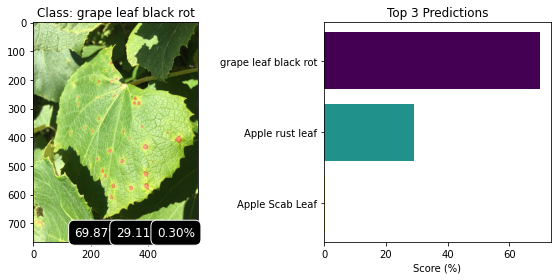

In [29]:
image_path = "test/grape leaf black rot/grape leaf black rot (3).jpg"
top_probs, top_indices = predict_single_image(model, image_path, device, top_k=3)
display_image_with_predictions(image_path, top_probs, top_indices, test_dataset.classes)

In [30]:
def print_predictions(top_probs, top_indices, class_names):
    print("Predictions:")
    for i in range(len(top_indices)):
        print(f"Prediction {i+1}: {test_dataset.classes[top_indices[i]]}, Score: {top_probs[i] * 100:.5f}%")

print_predictions(top_probs, top_indices, test_dataset.classes)

Predictions:
Prediction 1: grape leaf black rot, Score: 69.87215%
Prediction 2: Apple rust leaf, Score: 29.10528%
Prediction 3: Apple Scab Leaf, Score: 0.29803%
